In [97]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

In [98]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 1. Load the data and get measurements

In [99]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 2

In [100]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [101]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [102]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 581)
GT S-parameters shape:  (10, 2, 581)
Y S-parameters shape:  (10, 2, 14)


In [103]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (581,)
Y frequencies shape:  (14,)


In [104]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  1000000000.0
Mean frequency spacing:  50000000.0
STD frequency spacing:  0.0
Mode frequency spacing:  50000000.0
Number of samples with non-equal spacing:  1


In [105]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [106]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  581
N_SPARAMS:  10


In [107]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 581])


In [108]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 581])


## Plot some stuff

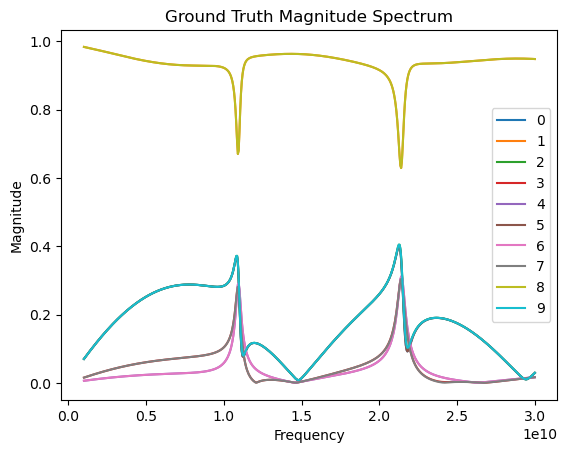

In [109]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

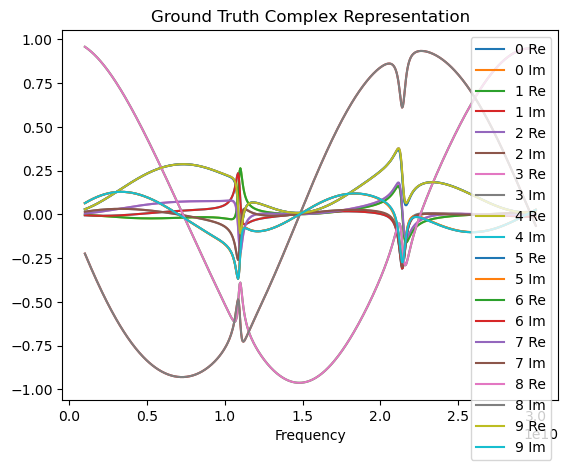

In [110]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [111]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 14

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True


print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  581
Number of Measurements:  14
Undersampling Ratio:  0.024096385542168676
[  0  44 133 223 312 401 490 580]
[  0  44  89 133 178 223 267 312 356 401 446 490 535 580]


In [112]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 8])
y_freqs shape:  (8,)


# 2. Network Setup

## Define network parameters

In [113]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF * 2] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = True

In [114]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  6
BASE NGF:  64
NGF:  [128, 128, 128, 128, 128, 128]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [115]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.5
               )
net = net.to(device)

In [116]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 581])


In [117]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  1386696


# 3. Run

## Define training parameters, losses, and track stats

In [118]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE
NUM_BURN_ITER = FIRST_ITER * 0 # TODO: use whatever value varun says is good
CURR_ITER = FIRST_ITER
SAMPLE_EVERY = 4

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = 200

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        print("num samples", len(sgld_outputs_by_sample[-1]))
        max_disagree_idx = find_max_variance(net, pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

        # Update the LR and noise level based on our decay rates
        # set_lr(optim, START_LR * LR_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) * NUM_ITER / ACTIVE_ITER_RATIO))
        # CUR_NOISE_LEVEL = START_NOISE_LEVEL * NOISE_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) *  NUM_ITER / ACTIVE_ITER_RATIO)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)

    for i in range(int(CURR_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (CURR_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        CURR_ITER = NUM_ITER
        is_initial_fit = False


    def find_max_variance(net, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        NUM_FORWARD_PASSES = 100
        sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
        sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
        for i in range(NUM_FORWARD_PASSES):
            sums_forward_pass_outputs += net.forward_with_z().cpu()
            sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

        mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
        std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))
        print("before squeeze and sum: ", std_forward_pass_outputs.shape)
        std_forward_pass_outputs = torch.squeeze(std_forward_pass_outputs)
        std_forward_pass_outputs = torch.sum(std_forward_pass_outputs, dim=0)
        print("after squeeze and sum: ", std_forward_pass_outputs.shape)

        _, idxs = torch.topk(std_forward_pass_outputs, len(std_forward_pass_outputs))

        for idx in idxs:
            if idx.item() not in kept_inds:
                print("picked: ", idx.item())
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  0.03246879577636719
NOISE LEVEL:  0.9997841559452123

ITER  999
TIME:  25.797023057937622
NOISE LEVEL:  0.8058421877614811

ITER  1999
TIME:  51.51543593406677
NOISE LEVEL:  0.6493816315762093

ITER  2999
TIME:  77.26064348220825
NOISE LEVEL:  0.5232991146814924

ITER  3999
TIME:  103.00088047981262
NOISE LEVEL:  0.42169650342857945

ITER  4999
TIME:  128.721697807312
NOISE LEVEL:  0.3398208328942537

ITER  5999
TIME:  154.4334056377411
NOISE LEVEL:  0.27384196342643363

ITER  6999
TIME:  180.2096655368805
NOISE LEVEL:  0.22067340690845663

ITER  7999
TIME:  205.91145944595337
NOISE LEVEL:  0.1778279410038904

ITER  8999
TIME:  231.58042860031128
NOISE LEVEL:  0.14330125702369473

ITER  9999
TIME:  257.32099294662476
NOISE LEVEL:  0.1154781984689445

ITER  10999
TIME:  283.03947854042053
NOISE LEVEL:  0.09305720409296872

ITER  11999
TIME:  308.72760009765625
NOISE LEVEL:  0.07498942093324455

ITER  12999
TIME:  334.41975712776184
NOISE LEVEL:  0.06042963902381247

ITER 

In [119]:
NUM_FORWARD_PASSES = 100
sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
for i in range(NUM_FORWARD_PASSES):
    sums_forward_pass_outputs += net.forward_with_z().cpu()
    sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

# out = sgld_means_by_sample[0]

print(mean_forward_pass_outputs.shape)
print(std_forward_pass_outputs.shape)

torch.Size([1, 20, 581])
torch.Size([1, 20, 581])


## Plot metrics and outputs

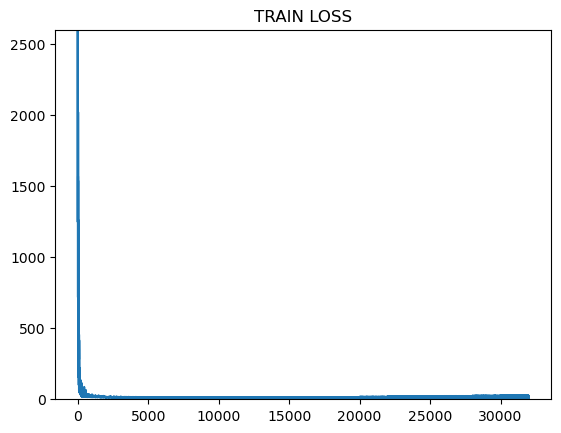

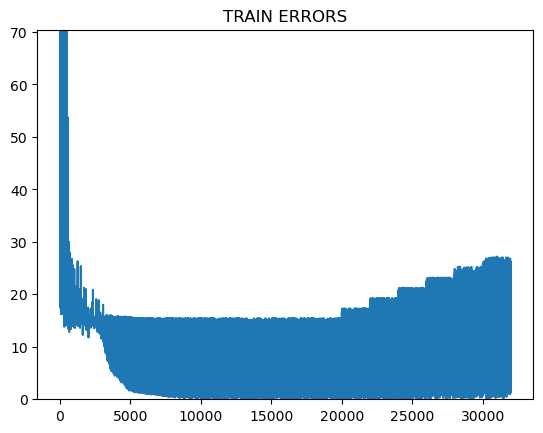

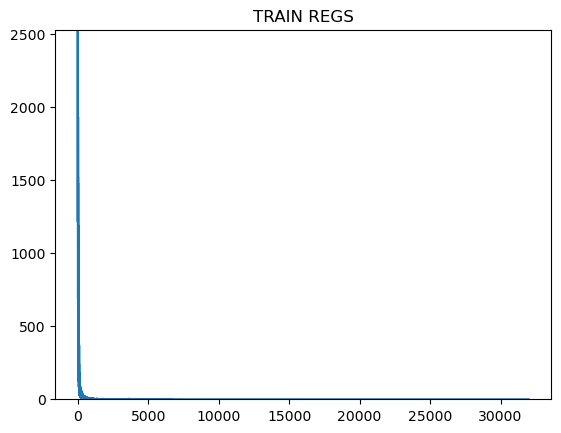

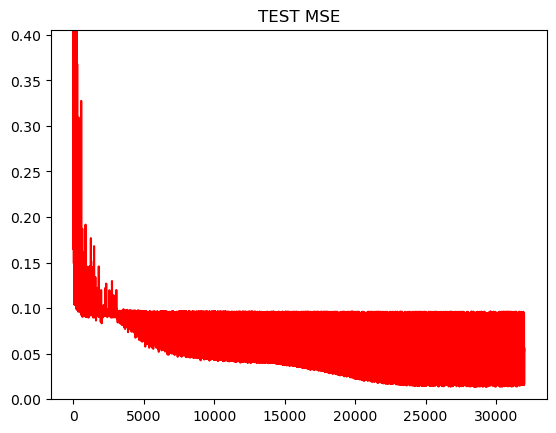

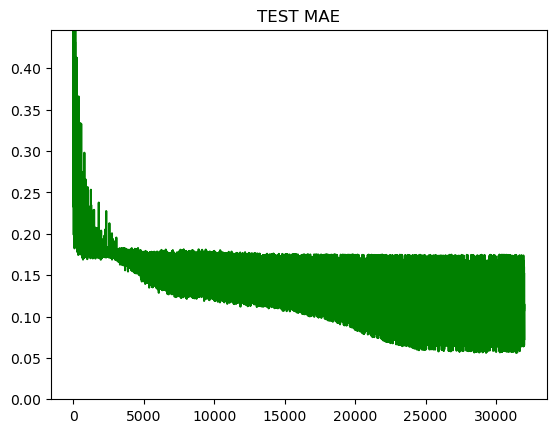

In [120]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [121]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.05354539677500725
Best Test MSE:  0.013850376941263676
Best Test MSE Iteration:  28455


In [122]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case02/case02.s4p
[1.000e+09 3.200e+09 7.650e+09 1.215e+10 1.660e+10 1.830e+10 1.905e+10
 2.000e+10 2.105e+10 2.110e+10 2.115e+10 2.120e+10 2.550e+10 3.000e+10]
Performing fit with 1 poles.
  Fitting took 0.027142880484461784 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.010431468486785889 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 2 (err 0.015213781947360103 vs 0.03719528523891271)
Performing fit with 3 poles.
  Fitting took 0.040834711864590645 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 4 (err 0.0014456313813951925 vs 0.015213781947360103)
Performing fit with 4 poles.
  Fitting took 0.030151205137372017 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better

In [123]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(mean_forward_pass_outputs)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

# print("Final DIP MSE: ", test_mses[-1])
print("Mean DIP MSE: ", nn.MSELoss()(mean_forward_pass_outputs.to(device), x).item())
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())

torch.Size([581, 4, 4, 2])
torch.Size([581, 4, 4, 2])
torch.Size([14, 4, 4, 2])
(581, 4, 4, 2)
(581, 4, 4, 2)
(10, 2, 581)
(10, 2, 581)
float32
float32
DIP PSNR:       20.28448260178957
VF PSNR:        40.05985768459064
Mean DIP MSE:  0.03746379166841507
VF MSE:         0.0003945247153751552


(581,)
torch.Size([20, 581])
torch.Size([1, 20, 581])
torch.Size([1, 20, 14])
torch.Size([1, 20, 581])
torch.Size([1, 20, 581])


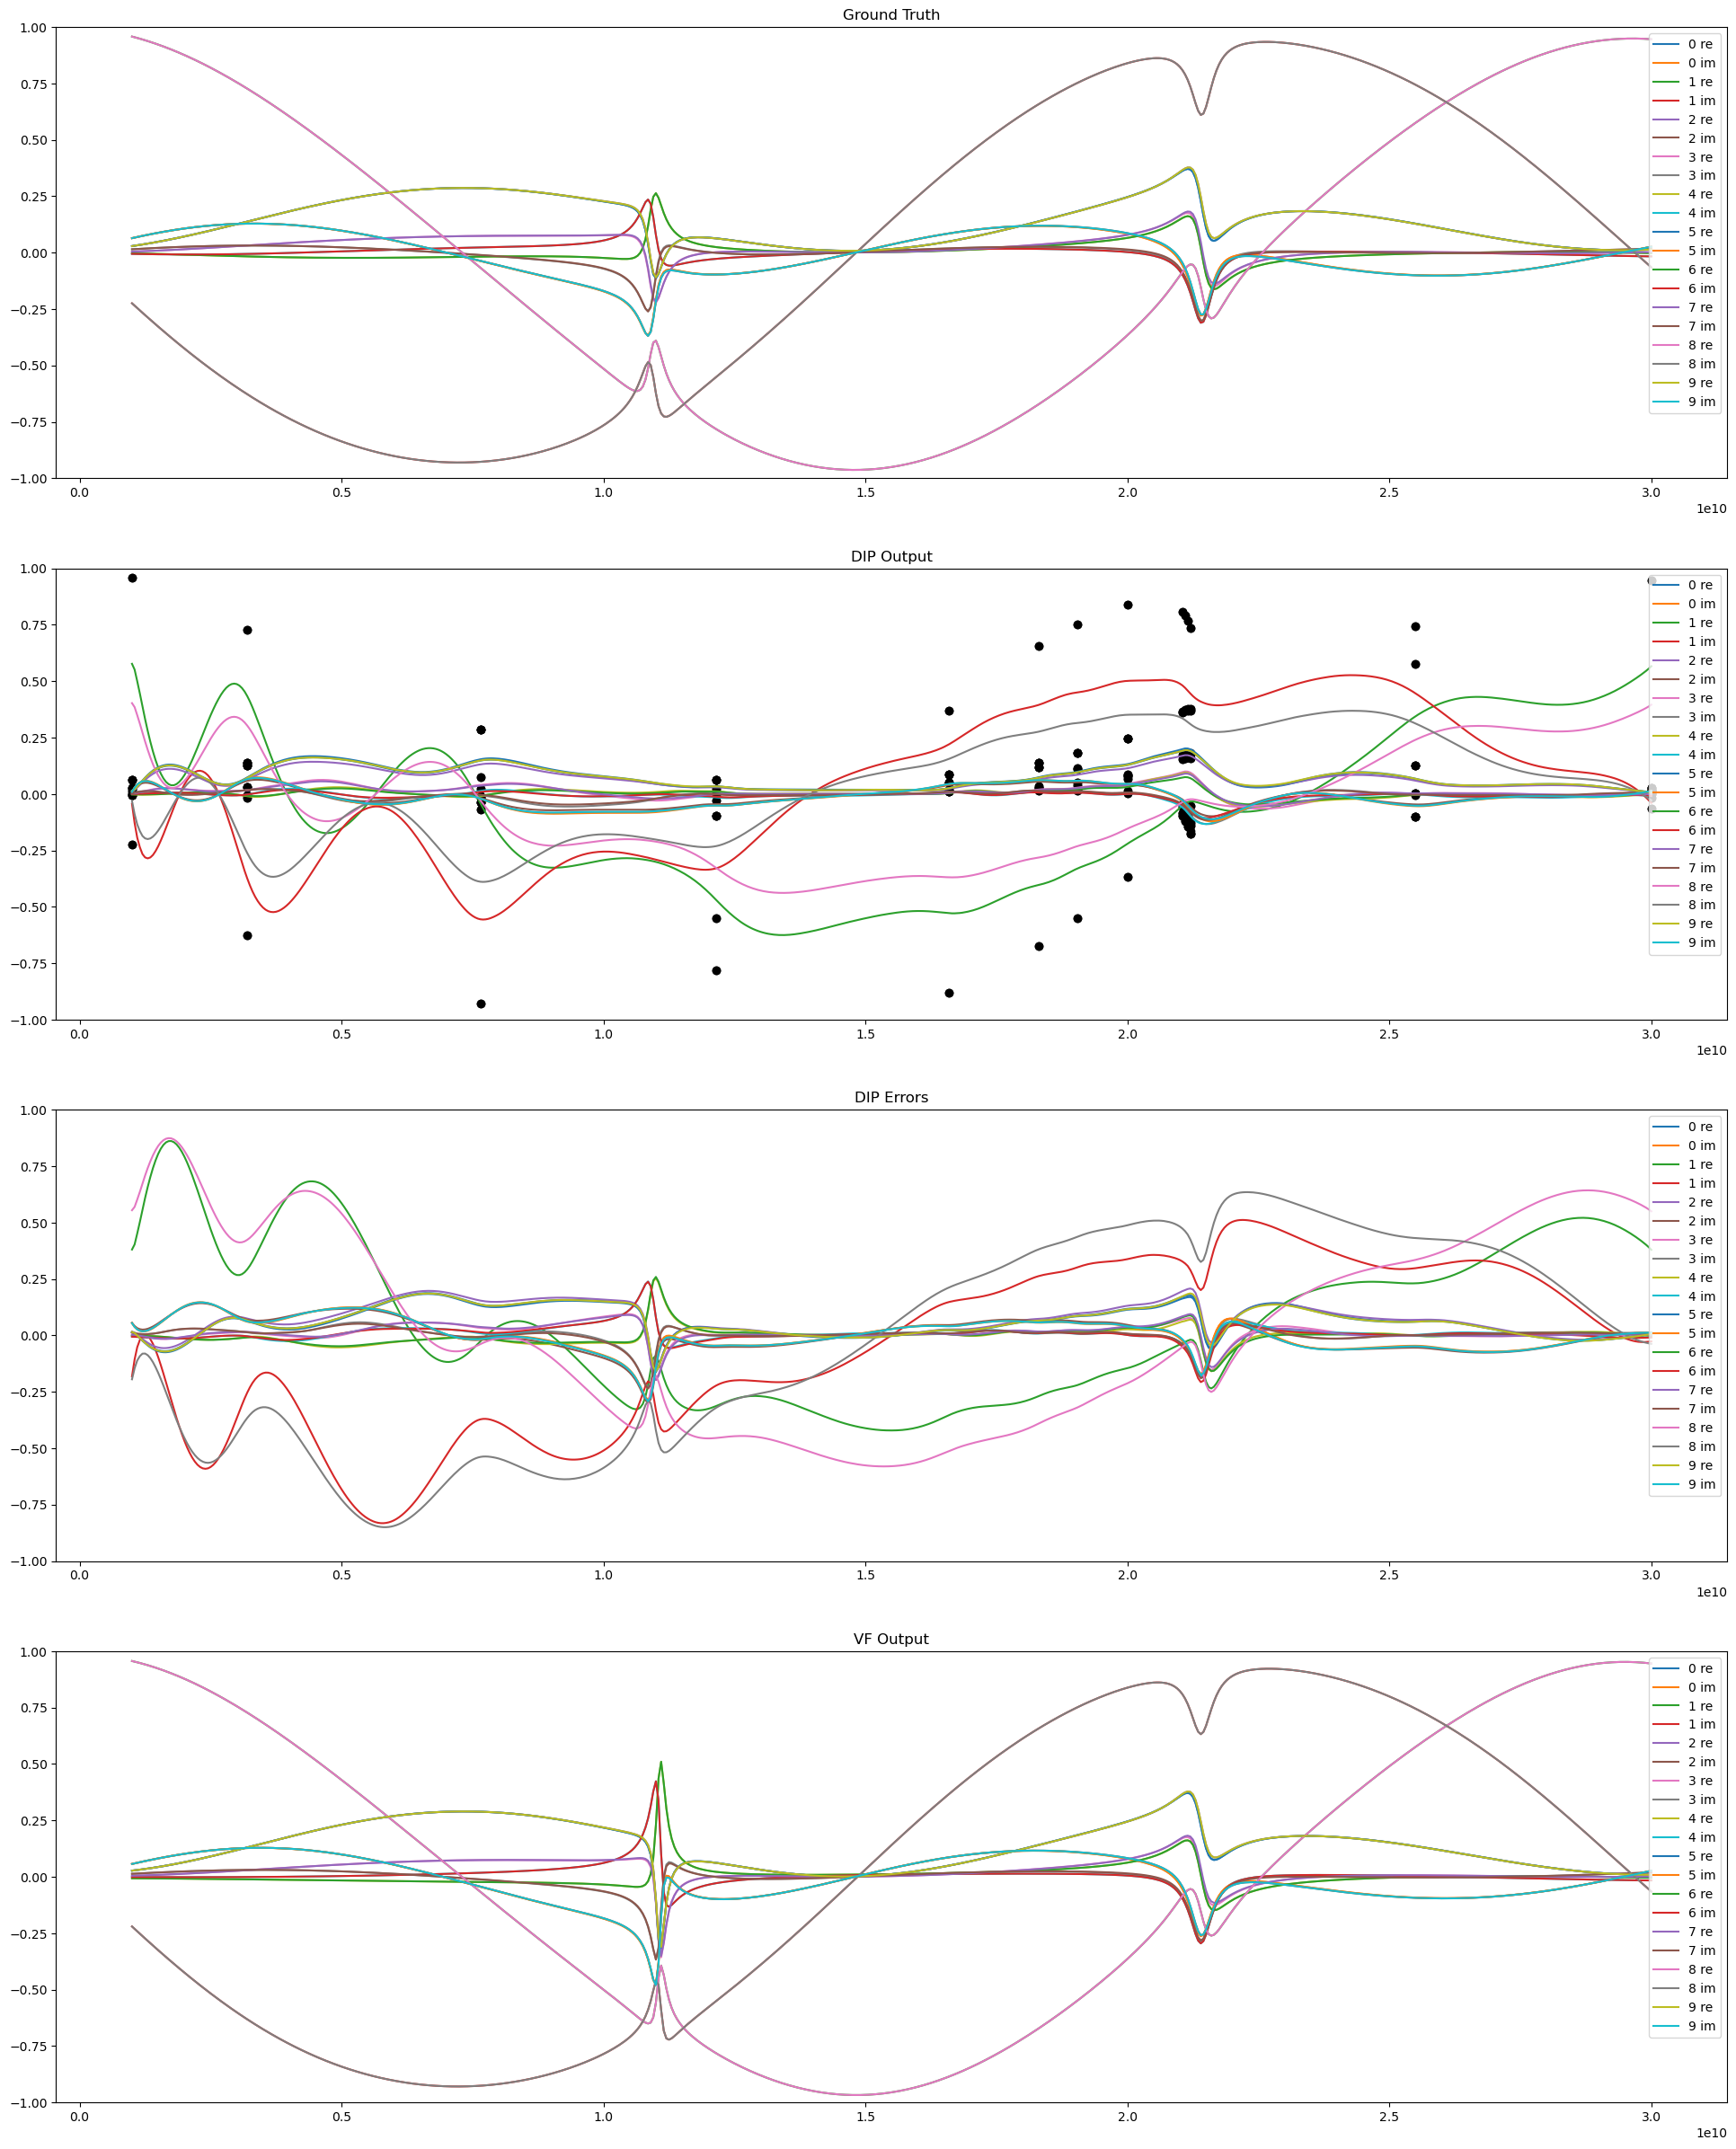

In [124]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, sgld_means_by_sample[-1][None,:][0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, sgld_means_by_sample[-1][None,:][0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [125]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[1.3582e-02, 1.9325e-02, 3.1172e-02, 4.3549e-02, 5.6364e-02, 6.8103e-02,
         7.9111e-02, 8.8923e-02, 9.7501e-02, 1.0479e-01, 1.1074e-01, 1.1541e-01,
         1.1878e-01, 1.2097e-01, 1.2197e-01, 1.2196e-01, 1.2092e-01, 1.1899e-01,
         1.1620e-01, 1.1272e-01, 1.0856e-01, 1.0395e-01, 9.8846e-02, 9.3484e-02,
         8.7875e-02, 8.2200e-02, 7.6464e-02, 7.0862e-02, 6.5400e-02, 6.0268e-02,
         5.5461e-02, 5.1121e-02, 4.7258e-02, 4.4160e-02, 4.1823e-02, 4.0360e-02,
         3.9781e-02, 4.0154e-02, 4.1485e-02, 4.3793e-02, 4.7091e-02, 5.1295e-02,
         5.6373e-02, 6.2155e-02, 6.8612e-02, 7.5144e-02, 8.1793e-02, 8.8238e-02,
         9.4494e-02, 1.0049e-01, 1.0624e-01, 1.1175e-01, 1.1701e-01, 1.2194e-01,
         1.2653e-01, 1.3079e-01, 1.3472e-01, 1.3831e-01, 1.4155e-01, 1.4456e-01,
         1.4719e-01, 1.4941e-01, 1.5133e-01, 1.5295e-01, 1.5434e-01, 1.5545e-01,
         1.5634e-01, 1.5693e-01, 1.5731e-01, 1.5749e-01, 1.5747e-01, 1.5726e-01,
         1.5688e-01, 1.5633e

In [126]:
print(dip_errors[-1])

tensor([[ 1.5879e-02,  1.1357e-02,  6.4759e-04, -1.0417e-02, -2.1833e-02,
         -3.2061e-02, -4.1476e-02, -4.9603e-02, -5.6409e-02, -6.1841e-02,
         -6.5843e-02, -6.8494e-02, -6.9756e-02, -6.9768e-02, -6.8515e-02,
         -6.6182e-02, -6.2754e-02, -5.8377e-02, -5.3074e-02, -4.7031e-02,
         -4.0253e-02, -3.2971e-02, -2.5161e-02, -1.7050e-02, -8.6574e-03,
         -1.6969e-04,  8.4054e-03,  1.6866e-02,  2.5205e-02,  3.3224e-02,
          4.0932e-02,  4.8178e-02,  5.4952e-02,  6.0952e-02,  6.6184e-02,
          7.0527e-02,  7.3969e-02,  7.6440e-02,  7.7931e-02,  7.8421e-02,
          7.7892e-02,  7.6432e-02,  7.4073e-02,  7.0989e-02,  6.7209e-02,
          6.3354e-02,  5.9382e-02,  5.5624e-02,  5.2057e-02,  4.8752e-02,
          4.5701e-02,  4.2886e-02,  4.0311e-02,  3.8079e-02,  3.6177e-02,
          3.4606e-02,  3.3367e-02,  3.2457e-02,  3.1901e-02,  3.1568e-02,
          3.1602e-02,  3.2045e-02,  3.2787e-02,  3.3805e-02,  3.5051e-02,
          3.6563e-02,  3.8272e-02,  4.

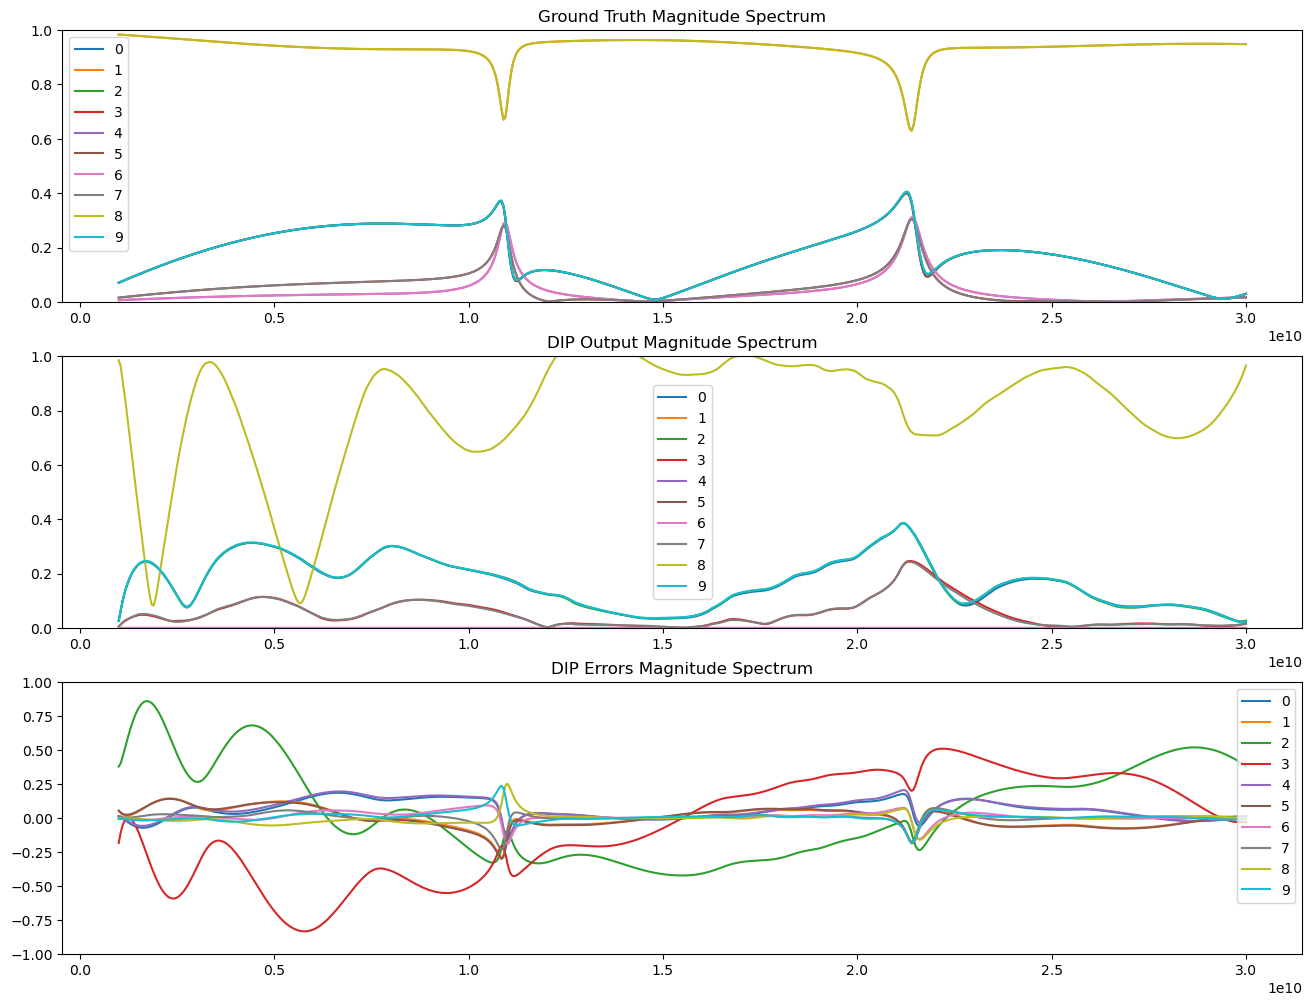

In [127]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [128]:
print(kept_inds)

[  0  44 133 223 312 346 361 380 401 402 403 404 490 580]
